# Import Packages

In [2]:
import glob

#Numpy
import numpy as np
import scipy

#For image plotting
import skimage.io
import skimage.filters as sf
from skimage import io, measure, filters, transform, morphology

#Matplotlib plotting packages
import matplotlib.pyplot as plt

# For loading bars
from tqdm.notebook import tqdm as tqdm

import pandas as pd

# Import Images

In [3]:
#Import Stack
file_path = '../../../../data/gliding/'
file_folder = '2023-03-23_Gliding/470/2023-Mar23_AnaGliding_Ncd-cherry-MT488_ATP470_lowATPload_5min_1/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

frames = np.arange(len(im_stack))

#Import Background
bg_file_path = '../../../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

Let us create a maximum projection. This will help us identify where MT tracks are to do center identificaiton

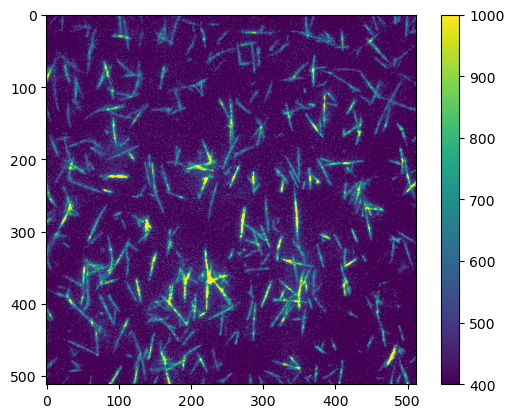

In [4]:
start=10
stop = 61
im = np.amax(im_stack[start:stop], axis=0)
plt.imshow(im, vmin=400, vmax = 1000)
plt.colorbar()

### Creating and looking at max proj

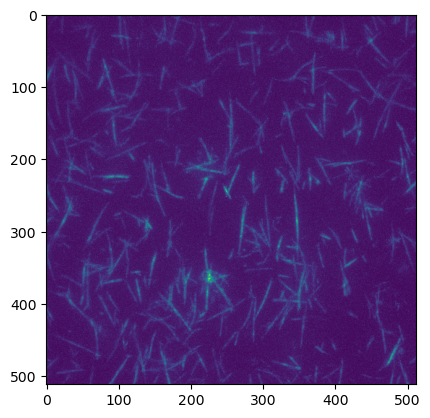

In [3]:
# Define a max projection
im_max = np.amax(im_stack, axis=0)
plt.imshow(im_max)

In [6]:
#Define the number of frames you want to project over
proj_interval = 20

#Create an array of all the max proj
max_stack = []
for i in range(round(len(im_stack)/proj_interval)):
    proj = np.amax(im_stack[i*proj_interval:(i+1)*proj_interval], axis=0)
    max_stack.append(proj)
max_stack = np.array(max_stack)

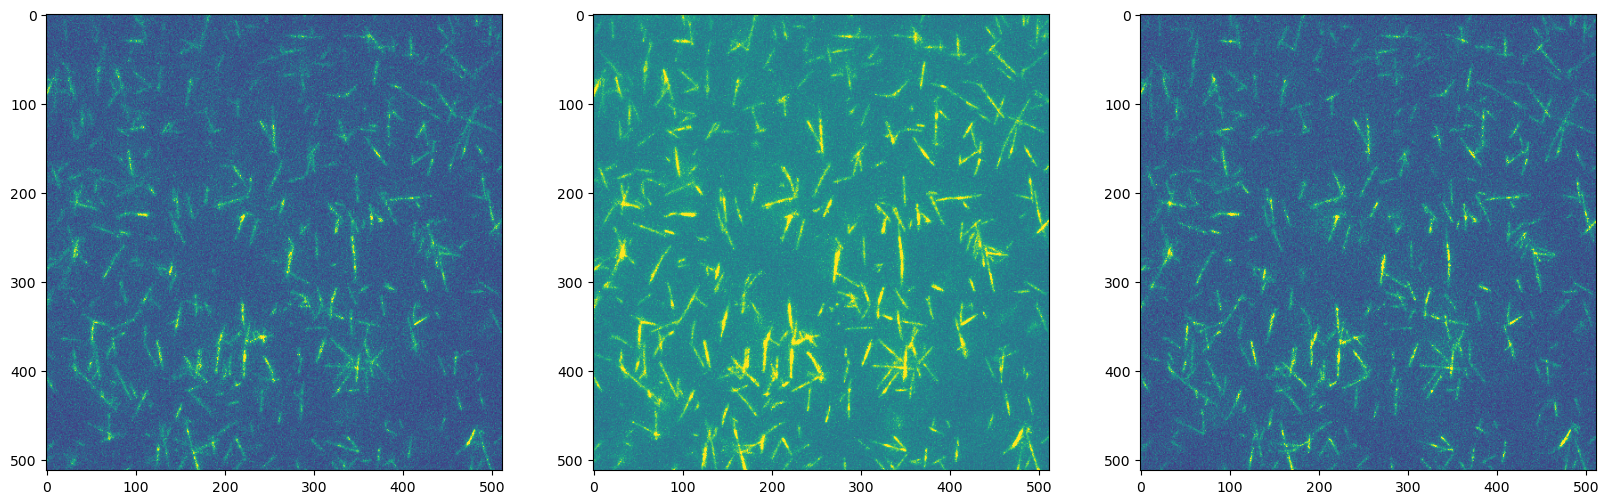

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(im_stack[0], vmin = 0, vmax = 800)
ax[1].imshow(max_stack[0], vmin = 0, vmax = 800)
ax[2].imshow(im_stack[proj_interval], vmin = 0, vmax = 800)

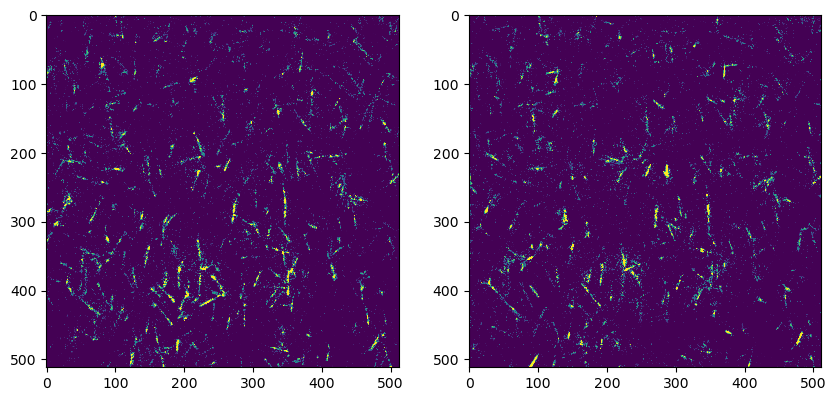

In [95]:
fig,ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(max_stack[0]-im_stack[0], vmin = 200 , vmax=400)
ax[1].imshow(max_stack[1]-im_stack[20], vmin = 200 , vmax=400)

# Process the Max Projeciton

### First normalize the image

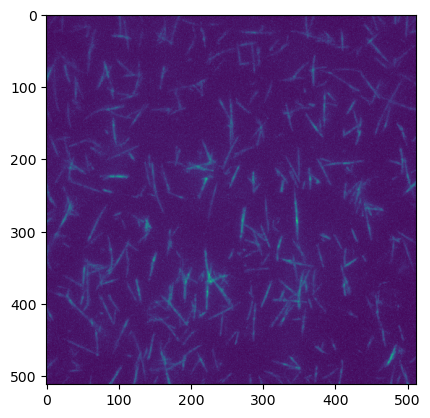

In [5]:
image_norm = (im - im.min()) / (im.max() - im.min())
plt.imshow(image_norm)

### Thresholding
Perform Niblack thresholding to identify bright patches
window size helps add to connectivity of patches. It takes the difference of the mean by the standard deviation within a window of specified size and weights the standard dev by k
T = m(x,y) - k * s(x,y)

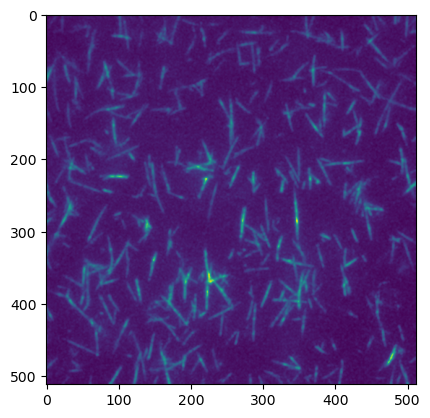

In [7]:
thresh_niblack = filters.threshold_niblack(image_norm, window_size=3, k=0.001)
plt.imshow(thresh_niblack)

Otsu

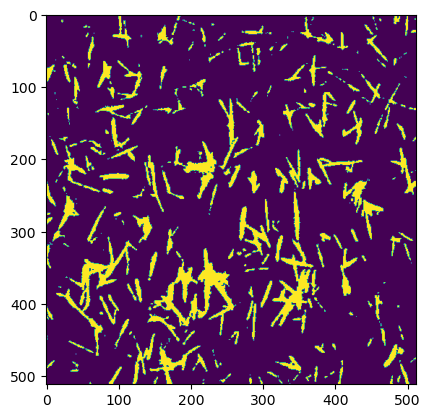

In [8]:
thresh_otsu = filters.threshold_otsu(thresh_niblack)
im_thresh = (thresh_niblack > thresh_otsu)
plt.imshow(im_thresh)

Label each region

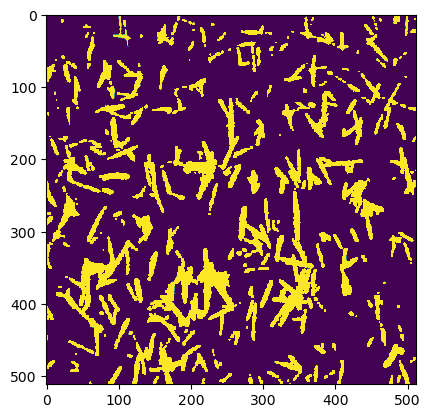

In [10]:
im_label, n_labels = measure.label(im_thresh, return_num=True)
unique_regions, region_counts = np.unique(im_label, return_counts=True)
plt.imshow(im_label, vmin=0.5, vmax=1)

Get rid of microtubules too close to the edge

In [13]:
#Remove border
edge=3
im_border = np.copy(im_label)
border = np.ones(np.shape(im_label))
#Set only ones to border
border[edge:-1*edge,edge:-1*edge] -= 1

#Ask if label in the border comes up and if so set those points to zero
for n in np.unique(im_border):
    if np.any(border * [im_border==n+1]):
        im_border[im_border==n+1] = 0

im_internal = im_border

Remove small stuff... 6.2 pix/um Remove 20px area seems ok

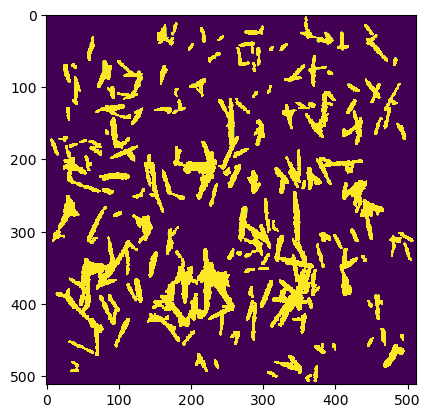

In [14]:
area_thresh = 20
#make a dictionary of region I.D. number and amount of counts for each I.D.
dict_area = dict(zip(unique_regions,region_counts))
im_sized = np.copy(im_internal)
for label in unique_regions:
    if label > 0 and dict_area[label]<=area_thresh:
        im_sized[im_sized==label] = 0
plt.imshow(im_sized, vmin=0, vmax=0.5)

Thin it out

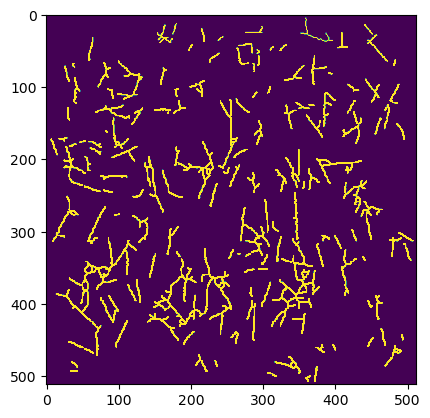

In [15]:
 #Thin each region - preserve connectivity but strip away any padding on the outside to get "skeleton"s
im_thinned = morphology.thin(im_sized)
im_relabel = measure.label(im_thinned)
plt.imshow(im_relabel, vmin=0, vmax=0.5)

Oof the tricky part, identify lines with the hough transfom. This thing plots many lines through each point and looks for the perpendicular that goes through the origin. Looks over all the points to find what line angle (theta from origin x axis) has the same radial distance and considers that to be the best fit line to all the points ugh. can have multiple angles for multiple lines, why we specifically want 2 idk, all others give real bad results. maybe its about the front and bakc of the ellipse?

In [17]:
padding=1
min_dist=1
min_angle=5
im_cleaned = im_relabel.copy()
test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
for n in np.unique(im_relabel)[1:]:
    x,y = np.where(im_relabel==n)
    mt_segment = im_relabel[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)
    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                            min_distance=min_dist,
                                            min_angle=min_angle,
                                            num_peaks=2)
    if len(angles)==2:
        im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

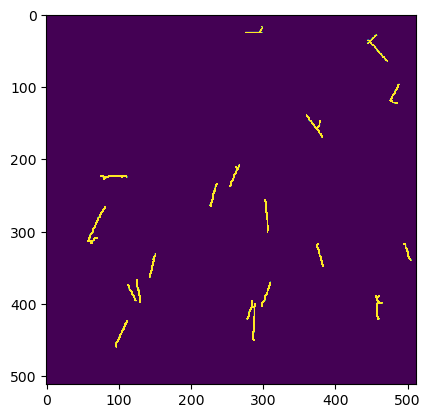

In [18]:
plt.imshow(im_cleaned,vmin=0, vmax=0.5)

Extract all the properties!!

In [21]:
#Determine properties
im_props = measure.regionprops_table(im_cleaned, im,
                            properties=['area', 'major_axis_length',
                                        'minor_axis_length','centroid',
                                        'orientation', 'eccentricity',
                                        'label', 'perimeter'])
df = pd.DataFrame(im_props)

Write a function for the line

In [22]:
def mt_track(xc, yc, l, theta):
    if theta>=np.pi:
        theta = theta-np.pi
    if np.abs(theta)<=np.pi/4 or np.abs(theta)>3*np.pi/4:
        xvals = np.arange(xc - np.abs(0.5*l*np.cos(theta)), xc + np.abs(0.5*l*np.cos(theta)))#.astype(int)
        yvals = (np.tan(theta)*xvals + (yc - np.tan(theta)*xc))#.astype(int)
    else:
        yvals = np.arange(yc - np.abs(0.5*l*np.sin(theta)), yc + np.abs(0.5*l*np.sin(theta)))#.astype(int)
        xvals = (yvals/np.tan(theta) + (xc - yc/np.tan(theta)))#.astype(int)
    
    return xvals, yvals

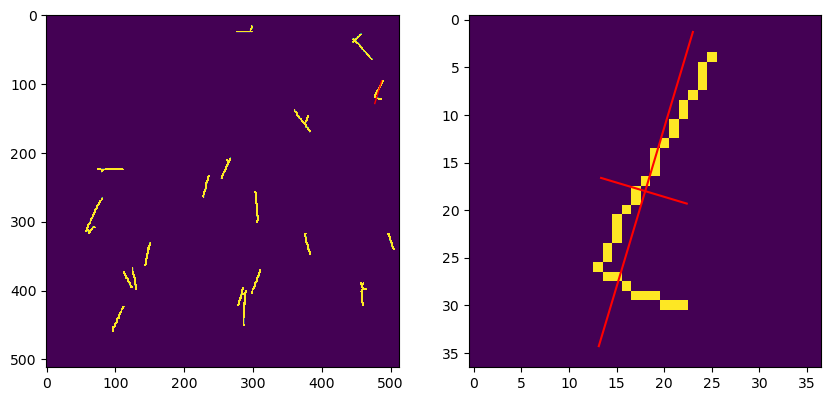

In [23]:
i = 2

# Calculate line
xc =  df.loc[i, 'centroid-1']
yc =  df.loc[i, 'centroid-0']
lmajor =  df.loc[i, 'major_axis_length']
lminor =  df.loc[i, 'minor_axis_length']
theta = -df.loc[i, 'orientation'] + (np.pi/2)

xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
#full frame
ax[0].imshow(im_cleaned, vmin=0, vmax=0.5)
ax[0].plot(xmajor, ymajor, color='r', lw=1)
#ax[0].scatter(xc, yc, color='r')

#Define crop
crop_win = int(lmajor/2+1)
cropmajx = xmajor-xc + crop_win #np.arange(crop_win - np.abs(0.5*l*np.cos(theta)), np.abs(crop_win + 0.5*l*np.cos(theta))).astype(int)
cropmajy = ymajor-yc + crop_win #(np.tan(theta)*(cropx) - 0.5*l*np.sin(theta))# - np.tan(theta)*(crop_win)).astype(int)
cropminx = xminor-xc + crop_win 
cropminy = yminor-yc + crop_win

ax[1].imshow(im_cleaned[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)], vmin=0, vmax=0.5)
ax[1].plot(cropmajx, cropmajy, color='r')
ax[1].plot(cropminx, cropminy, color='r')
#ax[1].scatter(crop_win,crop_win, color='red')

In [231]:
theta*180/np.pi

106.67083494419177

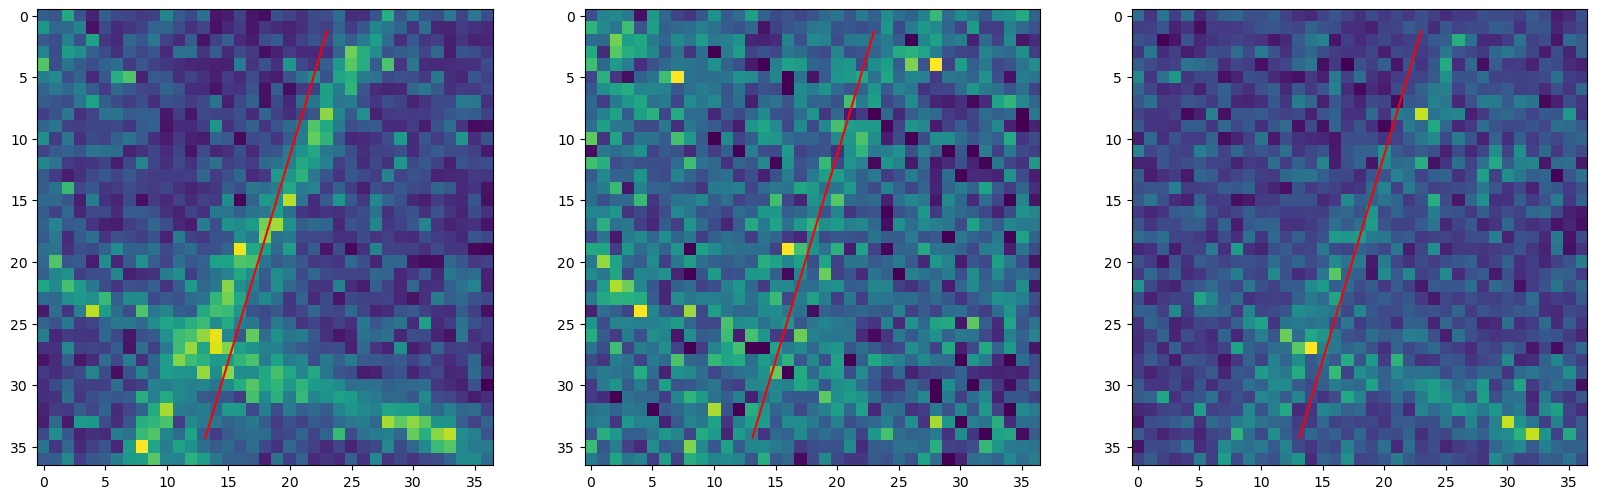

In [232]:
fig,ax = plt.subplots(1,3, figsize = (20,10))
ax[0].imshow(np.amax(im_stack[start:stop], axis=0)[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)])
ax[1].imshow(np.amax(im_stack[start:stop], axis=0)[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)] 
           - im_stack[10][int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)])
ax[2].imshow(im_stack[10][int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)])

ax[0].plot(cropmajx, cropmajy, color='r')
ax[1].plot(cropmajx, cropmajy, color='r')
ax[2].plot(cropmajx, cropmajy, color='r')

In [19]:
def kymo_func(kymo, sigma, pixel_size, plot=False):
    
    #Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu
    
    #Find the center of mass of each row
    row_coms = []
    for i, row_vals in enumerate(im_thresh):
        xdex = np.arange(len(row_vals))
        xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
        row_coms.append(xcom)
    row_coms = np.array(row_coms)
    
    #Find if there are nans
    plot_frames = np.where(~np.isnan(row_coms))[0]
    
    #Fit a line
    mfit, bfit = np.polyfit(row_coms[plot_frames], plot_frames, deg=1)
    
    #Calculate the speed (nm/s)
    speed = 1000*pixel_size/np.abs(mfit)
    
    ss_res =  np.sum((plot_frames - (mfit*row_coms[plot_frames]+bfit))**2)
    ss_tot = np.sum((plot_frames - np.average(plot_frames))**2)
    rsqrd = 1-(ss_res/ss_tot)

    #Plot
    if plot==True:
        plt.imshow(kymo)
        plt.scatter(row_coms[plot_frames], plot_frames, color='k')
        plt.plot(xdex, mfit*xdex+bfit, color='r')
        plt.title(str(np.round(speed,1)) + ' nm/s')
        plt.ylim(0, len(kymo)-1)

    return speed, rsqrd, len(plot_frames), [mfit, bfit]

In [20]:
pixel_size=0.161
mykymo = []
for im in im_stack[start:stop]:
    ls=[]
    for i in range(len(xmajor)):
        ls.append(im[int(ymajor[i]), int(xmajor[i])])
    mykymo.append(ls)
mykymo = np.array(mykymo)
speed, rsqrd, numpts, lineparams = kymo_func(mykymo, sigma = 2, pixel_size = pixel_size, plot=True)

NameError: name 'xmajor' is not defined

In [235]:
xmajor

array([486.72528203, 486.42582241, 486.12636279, 485.82690317,
       485.52744355, 485.22798394, 484.92852432, 484.6290647 ,
       484.32960508, 484.03014546, 483.73068584, 483.43122622,
       483.1317666 , 482.83230698, 482.53284736, 482.23338774,
       481.93392812, 481.6344685 , 481.33500888, 481.03554926,
       480.73608964, 480.43663002, 480.1371704 , 479.83771078,
       479.53825116, 479.23879155, 478.93933193, 478.63987231,
       478.34041269, 478.04095307, 477.74149345, 477.44203383,
       477.14257421, 476.84311459])

In [21]:
speeds=[]
r2 = []
num_centr = []

for i in range(len(df)):

    xc =  df.loc[i, 'centroid-1']
    yc =  df.loc[i, 'centroid-0']
    l =  df.loc[i, 'major_axis_length']
    theta = -df.loc[i, 'orientation'] + (np.pi/2)
    
    xtrack, ytrack = mt_track(xc, yc, l, theta)
    
    if len(xtrack)>1:
        mykymo = []

        for im in im_stack[10:61]:
            ls=[]
            for i in range(len(xtrack)):
                if int(ytrack[i])<512 and int(xtrack[i])<512:
                    ls.append(im[int(ytrack[i]), int(xtrack[i])])
            mykymo.append(ls)
        mykymo = np.array(mykymo)

        speed, rsqrd, num_centroids, lineparam = kymo_func(mykymo, sigma = 2, pixel_size = pixel_size)
        speeds.append(speed)
        r2.append(rsqrd)
        num_centr.append(num_centroids)
    else:
        df=dfdrop([i])
speeds = np.array(speeds)
r2 = np.array(r2)
num_centr = np.array(num_centr)
df['speed (nm/s)'] = speeds
df['r^2'] = r2
df['num points'] = num_centr

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_5445/3518485735.py:14: RuntimeWarning: invalid value encountered in long_scalars
  xcom = np.sum(row_vals*xdex)/np.sum(row_vals)


In [22]:
df

area  major_axis_length  minor_axis_length  centroid-0  centroid-1  \
0     30          30.079662           7.296615   23.800000  289.500000   
1     46          50.857043          13.091063   45.543478  456.434783   
2     32          34.904179           9.678979  111.875000  481.718750   
3     44          39.766711          13.080377  153.931818  372.818182   
4     32          38.416223           2.967018  222.750000  260.343750   
5     40          43.008357           3.179810  224.475000   92.100000   
6     31          37.050604           1.478918  250.000000  231.258065   
7     45          52.137851           1.585439  279.000000  305.111111   
8     62          65.535386           9.403086  295.467742   67.741935   
9     31          37.066411           1.716664  333.000000  378.548387   
10    24          28.913643           1.590290  328.541667  499.583333   
11    33          39.083406           1.633760  347.000000  147.000000   
12    31          36.439116           1.254067  383.000000  127.548387   
13    34          42.089213           1.401878  387.500000  304.235294   
14    23          29.848581           1.145320  385.000000  118.130435   
15    40          38.694345           6.310916  404.150000  458.600000   
16    78          60.219498          10.715247  420.012821  285.538462   
17    37          46.828128           1.885707  442.000000  103.486486   

    orientation  eccentricity  label  perimeter  speed (nm/s)       r^2  \
0     -1.374111      0.970132      5  29.071068     23.779447  0.156815   
1      0.611221      0.966303      8  54.426407     44.432477  0.582540   
2     -0.290961      0.960783     33  36.420310     76.687118  0.149945   
3      0.657903      0.944355     53  50.734019     41.760440  0.365148   
4     -0.394593      0.997013     73  33.798990     48.198416  0.977471   
5     -1.538833      0.997263     79  39.692388     39.891792  0.896850   
6     -0.263164      0.999203     82  32.727922     45.375514  0.952521   
7      0.085248      0.999538     88  45.071068     77.628219  0.989320   
8     -0.366691      0.989653     90  69.012193     41.671763  0.929669   
9      0.264820      0.998927    104  32.520815     44.862099  0.704277   
10     0.323107      0.998486    105  25.106602     55.647497  0.952037   
11    -0.226420      0.999126    110  34.935029     33.582189  0.623853   
12     0.191025      0.999408    117  31.071068     37.032428  0.010230   
13    -0.370090      0.999445    118  36.970563     52.782891  0.954957   
14     0.476194      0.999264    119  25.349242     17.750463  0.117089   
15    -0.002909      0.986610    122  40.556349     56.036450  0.960483   
16     0.032119      0.984042    123  79.591883    231.785398  0.195490   
17    -0.422973      0.999189    127  41.834524     36.614427  0.837466   

    num points  
0           51  
1           51  
2           43  
3           51  
4           51  
5           51  
6           48  
7           51  
8           51  
9           51  
10          51  
11          51  
12          51  
13          51  
14          51  
15          51  
16          51  
17          51

Text(0.5, 1.0, 'kymo')

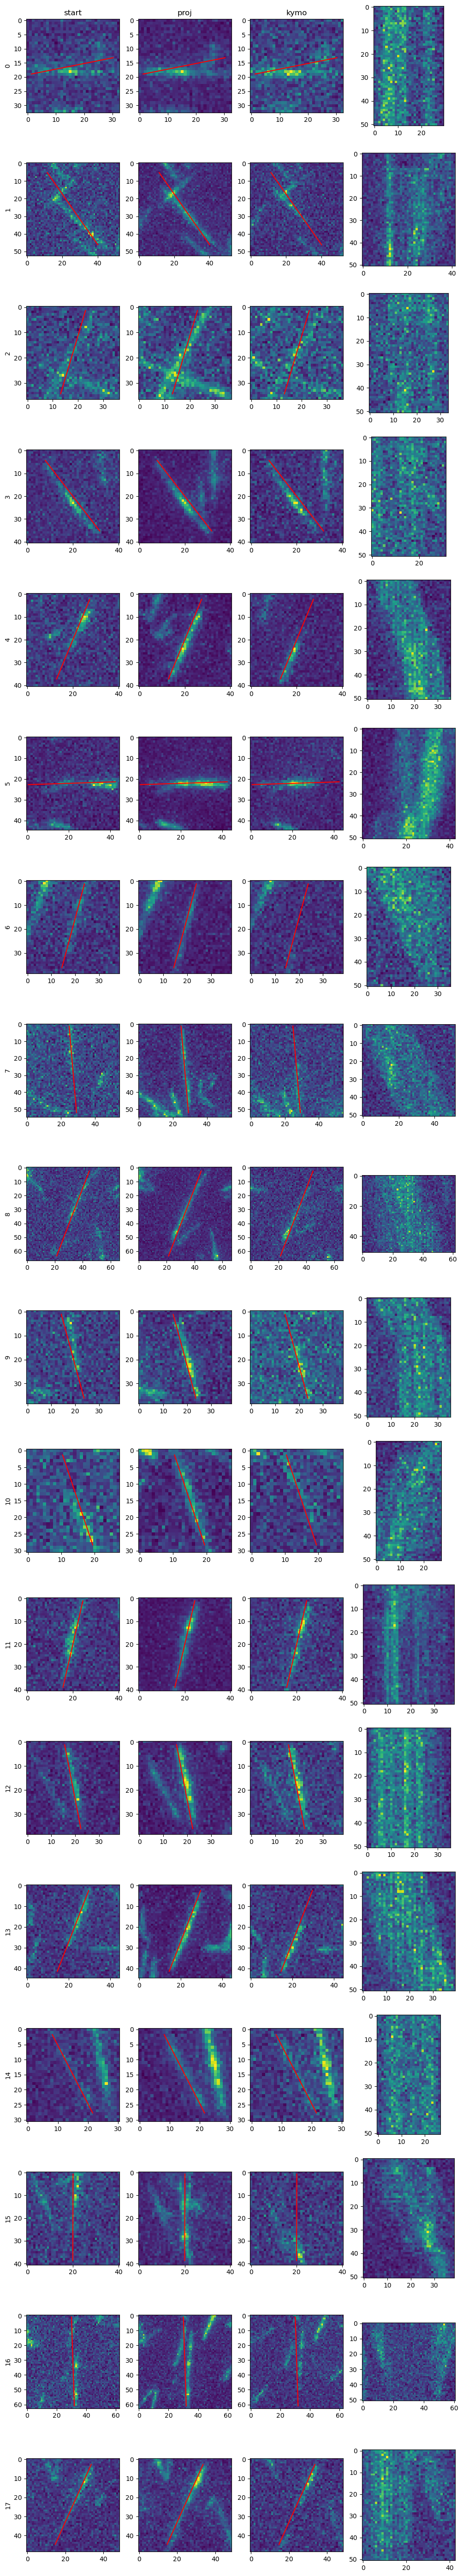

In [23]:
fig, ax = plt.subplots(len(df), 4, figsize = (12, 4*len(df)))
for i in range(len(df)):
    xc =  df.loc[i, 'centroid-1']
    yc =  df.loc[i, 'centroid-0']
    lmajor =  df.loc[i, 'major_axis_length']
    lminor =  df.loc[i, 'minor_axis_length']
    theta = -df.loc[i, 'orientation'] + (np.pi/2)

    xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
    xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)

    crop_win = int(lmajor/2+1)
    crop = np.s_[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)]
    
    cropmajx = xmajor-xc + crop_win 
    cropmajy = ymajor-yc + crop_win 
    
    ax[i][0].imshow(im_stack[start][crop])
    ax[i][1].imshow(np.amax(im_stack[start:stop], axis=0)[crop])
    ax[i][2].imshow(im_stack[stop-1][crop])
    
    ax[i][0].plot(cropmajx, cropmajy, color='r')
    ax[i][1].plot(cropmajx, cropmajy, color='r')
    ax[i][2].plot(cropmajx, cropmajy, color='r')
    
    ax[i][0].set_ylabel(i)
    
    mykymo = []
    for im in im_stack[start:stop]:
        ls=[]
        for j in range(len(xmajor)):
            ls.append(im[int(ymajor[j]), int(xmajor[j])])
        mykymo.append(ls)
    mykymo = np.array(mykymo)
    ax[i][3].imshow(mykymo)
    
ax[0][0].set_title('start')
ax[0][1].set_title('proj')
ax[0][2].set_title('stop')
ax[0][2].set_title('kymo')

In [24]:
df_good = df[df['r^2']>0.8]
df_good

area  major_axis_length  minor_axis_length  centroid-0  centroid-1  \
4     32          38.416223           2.967018  222.750000  260.343750   
5     40          43.008357           3.179810  224.475000   92.100000   
6     31          37.050604           1.478918  250.000000  231.258065   
7     45          52.137851           1.585439  279.000000  305.111111   
8     62          65.535386           9.403086  295.467742   67.741935   
10    24          28.913643           1.590290  328.541667  499.583333   
13    34          42.089213           1.401878  387.500000  304.235294   
15    40          38.694345           6.310916  404.150000  458.600000   
17    37          46.828128           1.885707  442.000000  103.486486   

    orientation  eccentricity  label  perimeter  speed (nm/s)       r^2  \
4     -0.394593      0.997013     73  33.798990     48.198416  0.977471   
5     -1.538833      0.997263     79  39.692388     39.891792  0.896850   
6     -0.263164      0.999203     82  32.727922     45.375514  0.952521   
7      0.085248      0.999538     88  45.071068     77.628219  0.989320   
8     -0.366691      0.989653     90  69.012193     41.671763  0.929669   
10     0.323107      0.998486    105  25.106602     55.647497  0.952037   
13    -0.370090      0.999445    118  36.970563     52.782891  0.954957   
15    -0.002909      0.986610    122  40.556349     56.036450  0.960483   
17    -0.422973      0.999189    127  41.834524     36.614427  0.837466   

    num points  
4           51  
5           51  
6           48  
7           51  
8           51  
10          51  
13          51  
15          51  
17          51

In [25]:
df_good['speed (nm/s)'].mean()

50.42744098419999

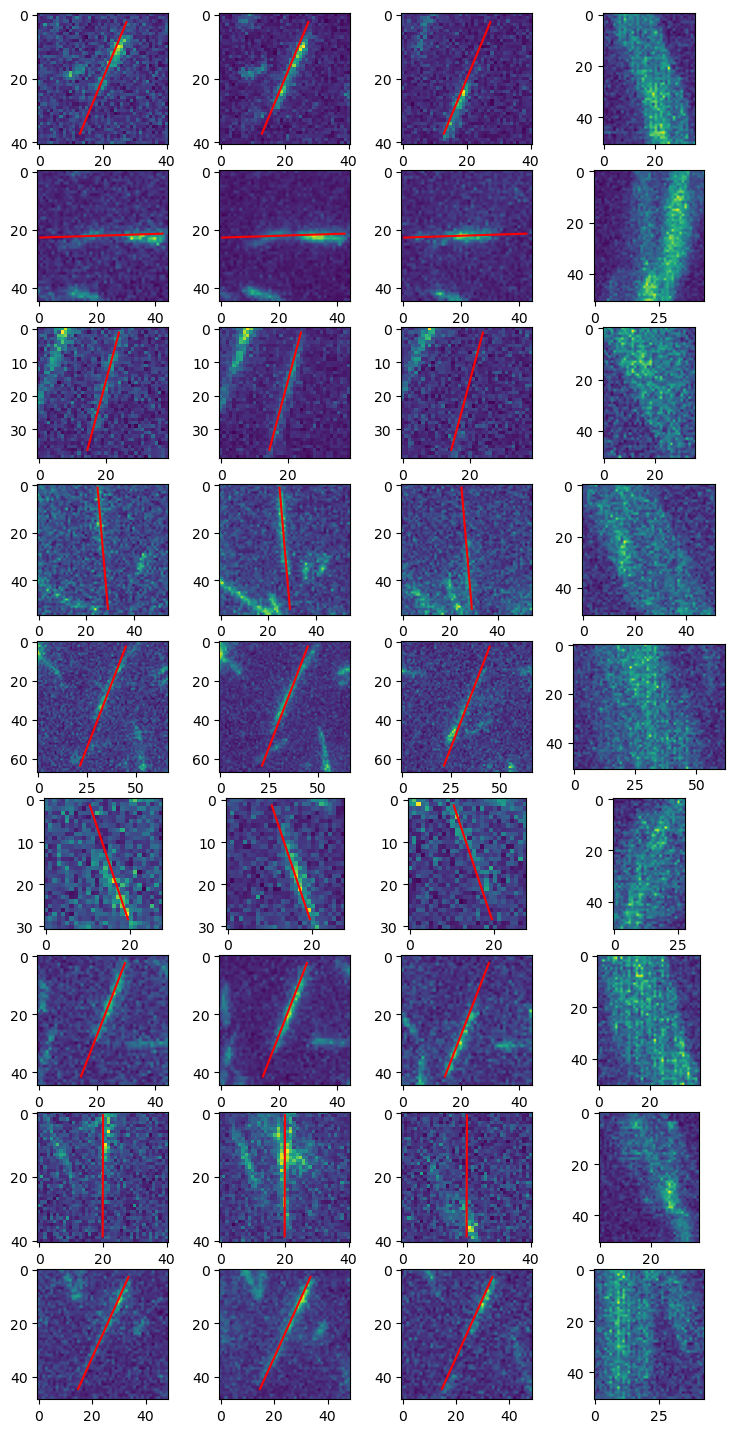

In [26]:
fig, ax = plt.subplots(len(df_good), 4, figsize = (9, len(df)))
for i, index in enumerate(df_good.index):
    xc =  df_good.loc[index, 'centroid-1']
    yc =  df_good.loc[index, 'centroid-0']
    lmajor =  df_good.loc[index, 'major_axis_length']
    lminor =  df_good.loc[index, 'minor_axis_length']
    theta = -df_good.loc[index, 'orientation'] + (np.pi/2)

    xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
    xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)

    crop_win = int(lmajor/2+1)
    crop = np.s_[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)]
    
    cropmajx = xmajor-xc + crop_win 
    cropmajy = ymajor-yc + crop_win 
    
    ax[i][0].imshow(im_stack[start][crop])
    ax[i][1].imshow(np.amax(im_stack[10:31], axis=0)[crop])
    ax[i][2].imshow(im_stack[stop-1][crop])
    
    ax[i][0].plot(cropmajx, cropmajy, color='r')
    ax[i][1].plot(cropmajx, cropmajy, color='r')
    ax[i][2].plot(cropmajx, cropmajy, color='r')
    
    mykymo = []
    for im in im_stack[start:stop]:
        ls=[]
        for j in range(len(xmajor)):
            ls.append(im[int(ymajor[j]), int(xmajor[j])])
        mykymo.append(ls)
    mykymo = np.array(mykymo)
    ax[i][3].imshow(mykymo)